In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
color_pal = sns.color_palette()
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [15]:
import sqlite3

conn = sqlite3.connect('../data/WARP.db')
df = pd.read_sql_query("SELECT * FROM training_set", conn)
conn.close()
# change datetime to index
df.set_index('target_datetime', inplace=True)
# convert to datetime
df.index = pd.to_datetime(df.index)
print(df.dtypes)


hour                          int64
day_of_week                   int64
month                         int64
day_of_year                   int64
hour_sin                    float64
hour_cos                    float64
weekday_sin                 float64
weekday_cos                 float64
yearday_sin                 float64
yearday_cos                 float64
local_datetime               object
is_dst                        int64
is_holiday                    int64
is_weekend                    int64
is_non_working_day            int64
Load                        float64
Price                       float64
Flow_BE                     float64
Flow_DE                     float64
Flow_GB                     float64
Flow_DK                     float64
Flow_NO                     float64
Total_Flow                  float64
temperature_2m              float64
wind_speed_10m              float64
apparent_temperature        float64
cloud_cover                 float64
snowfall                    

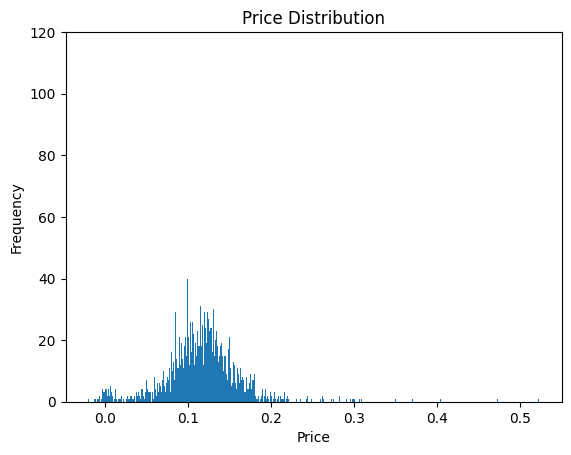

In [17]:
df['Price'].plot(kind='hist', bins=500)
plt.ylim(top=120)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

ModuleNotFoundError: No module named 'build_training_set'

In [ ]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Configuration
MODEL_CODE = "XGB_1fold_split"
PARAMETERS_USED = {
    "temp_2m": True,
    "shortwave_radiation": True,
    "windspeed_10m": True
}
timestamp_predict = pd.to_datetime("2025-03-15 00:00:00", utc=True)
TARGET = 'Price'

# Define features
COMMON_FEATURES = [
    'yearday_cos', 'yearday_sin', 'month',
    'shortwave_radiation', 'windspeed_10m', 'apparent_temperature', 'temperature_2m',
    'direct_normal_irradiance', 'diffuse_radiation',
    'cloud_cover', , 'hour_cos', 'hour_sin', 'is_non_working_day',
    'weekday_sin', 'weekday_cos', 'is_holiday',
]

# Add Load only to training features
TRAIN_FEATURES = COMMON_FEATURES + ['Load', 'Flow_NO', 'Flow_GB', 'Flow_BE', 'Wind_Vol', 'Solar_Vol']
TEST_FEATURES = COMMON_FEATURES

# Sort by index
df = df.sort_index()

# Train-test split based on timestamp_predict
train = df[df.index < timestamp_predict]
test = df[df.index >= timestamp_predict]

X_train = train[TRAIN_FEATURES]
y_train = train[TARGET]
X_test = test[TEST_FEATURES]
y_test = test[TARGET]

# Train model
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1200,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.02
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

y_pred = reg.predict(X_test)

# Store predictions
y_test.index = pd.to_datetime(y_test.index)
pred_df = pd.DataFrame({
    'datetime': y_test.index,
    'y_true': y_test.values,
    'y_pred': y_pred
})

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"1-Fold RMSE: {rmse:.4f}")

# Collect results
results = []
for _, row in pred_df.iterrows():
    results.append({
        'timestamp_predict': timestamp_predict.strftime('%d-%m-%Y %H:%M'),
        'datetime': row['datetime'].strftime('%d-%m-%Y %H:%M'),
        'model_code': MODEL_CODE,
        'price': round(row['y_pred'], 4),
        'true_price': round(row['y_true'], 4),
        'RSME': round(rmse, 4),
        'fold': 1,
        'parameters(JSON)': json.dumps(PARAMETERS_USED)
    })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_log.csv", mode='a', index=False)

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Feature and target setup
features = ['hour_cos', 'Load', 'hour_sin', 'weekday_sin', 'weekday_cos', 'Solar_Vol', 'Wind_Vol',
            'WindOffshore_Vol', 'is_holiday','Total_Flow']

target = 'Price'

# Safe datetime handling
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
else:
    print("'datetime' column not found in columns. Sorting by index instead.")
    df = df.sort_index()

# Forecast settings
start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-05 12:00", tz='UTC')
lag = timedelta(hours=36)
forecast_horizon = timedelta(hours=144)

# Store RMSEs
rmses = []

current_time = start_date
while current_time <= end_date:
    train_data = df[df.index < current_time]
    test_start = current_time + lag
    test_end = test_start + forecast_horizon
    test_data = df[(df.index >= test_start) & (df.index < test_end)]

    if test_data.empty:
        print(f"No test data for forecast starting at {current_time}")
        current_time += timedelta(days=1)
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train and predict
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    print(f"Forecast origin: {current_time}, Predicting {test_start} to {test_end}, RMSE: {rmse:.3f}")

    current_time += timedelta(days=1)

# Summary
avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE over {len(rmses)} runs: {avg_rmse:.3f}")

'datetime' column not found in columns. Sorting by index instead.
Forecast origin: 2025-03-13 12:00:00+00:00, Predicting 2025-03-15 00:00:00+00:00 to 2025-03-21 00:00:00+00:00, RMSE: 0.021
Forecast origin: 2025-03-14 12:00:00+00:00, Predicting 2025-03-16 00:00:00+00:00 to 2025-03-22 00:00:00+00:00, RMSE: 0.029
Forecast origin: 2025-03-15 12:00:00+00:00, Predicting 2025-03-17 00:00:00+00:00 to 2025-03-23 00:00:00+00:00, RMSE: 0.033
Forecast origin: 2025-03-16 12:00:00+00:00, Predicting 2025-03-18 00:00:00+00:00 to 2025-03-24 00:00:00+00:00, RMSE: 0.033
Forecast origin: 2025-03-17 12:00:00+00:00, Predicting 2025-03-19 00:00:00+00:00 to 2025-03-25 00:00:00+00:00, RMSE: 0.033
Forecast origin: 2025-03-18 12:00:00+00:00, Predicting 2025-03-20 00:00:00+00:00 to 2025-03-26 00:00:00+00:00, RMSE: 0.031
Forecast origin: 2025-03-19 12:00:00+00:00, Predicting 2025-03-21 00:00:00+00:00 to 2025-03-27 00:00:00+00:00, RMSE: 0.029
Forecast origin: 2025-03-20 12:00:00+00:00, Predicting 2025-03-22 00:00:0

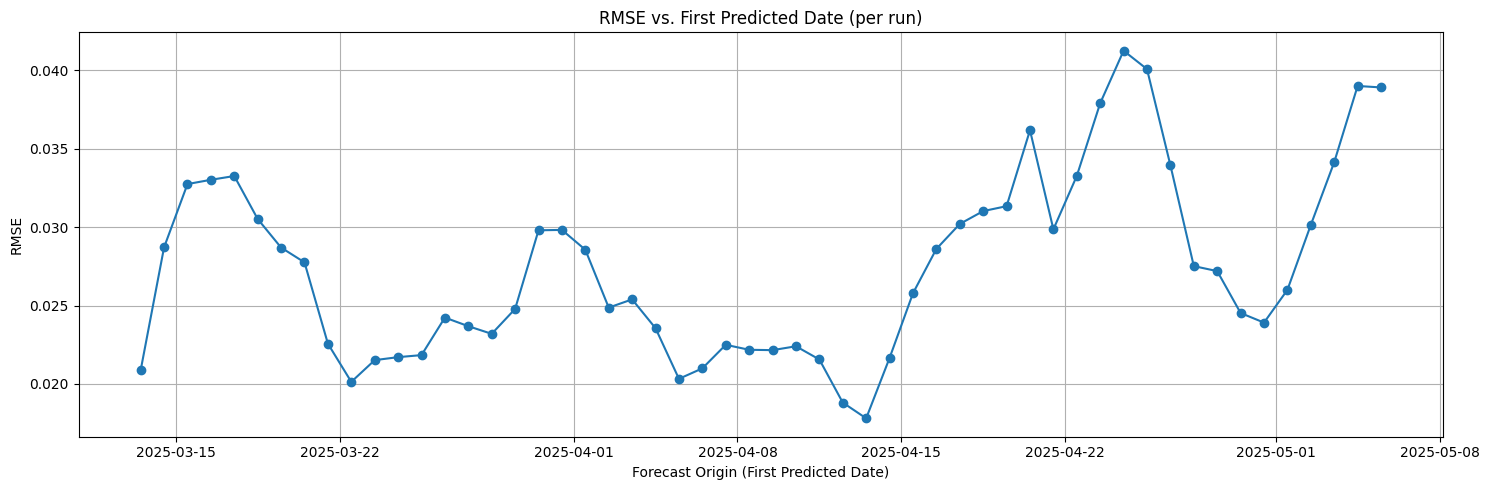

In [12]:
# Extract the forecast origin dates and RMSEs from the previous loop
forecast_origins = []
rmses_per_run = []

start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-05 12:00", tz='UTC')
num_runs = len(rmses)
current_time = start_date

for i in range(num_runs):
    forecast_origins.append(current_time)
    current_time += timedelta(days=1)

# Plot RMSE vs. forecast origin date
plt.figure(figsize=(15, 5))
plt.plot(forecast_origins, rmses, marker='o', linestyle='-', color=color_pal[0])
plt.title('RMSE vs. First Predicted Date (per run)')
plt.xlabel('Forecast Origin (First Predicted Date)')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

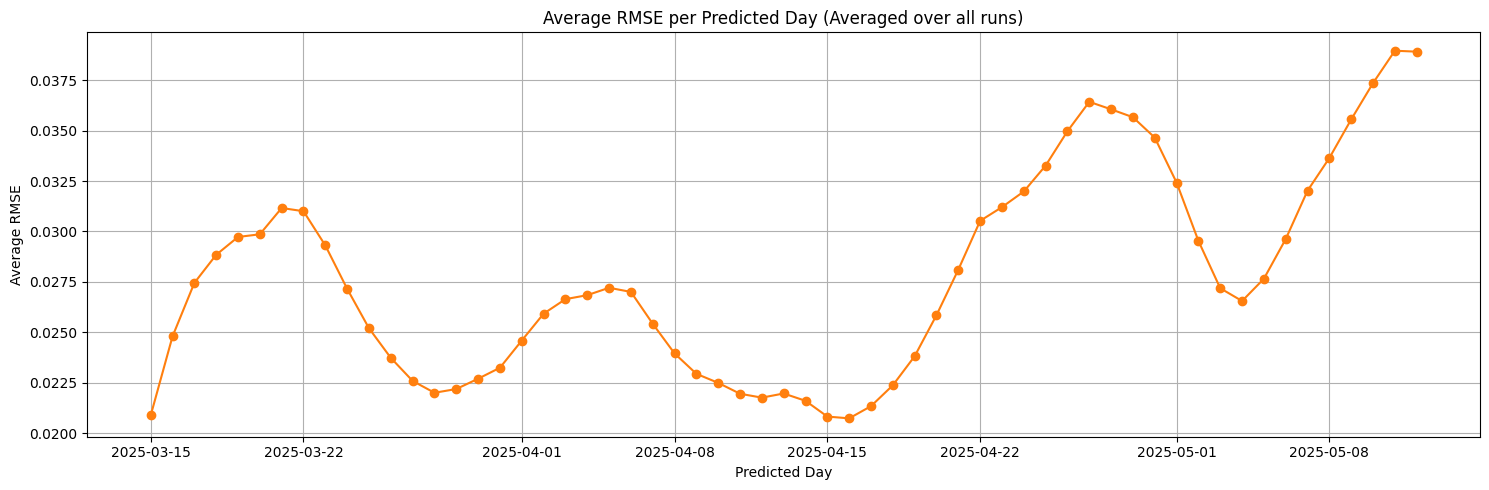

In [13]:
import pandas as pd
import numpy as np

# Calculate RMSE per day (averaged over all runs where the day is included in the forecast horizon)

# Assume forecast_origins and rmses are available from previous cells
# Each run predicts 6 days (144 hours), so for each run, map RMSE to each predicted day

# Build a DataFrame mapping each forecast run to its predicted days
forecast_horizon_days = 6
forecast_origin_dates = pd.to_datetime(forecast_origins)
rmse_per_day = {}

for run_idx, origin in enumerate(forecast_origin_dates):
    for day_offset in range(forecast_horizon_days):
        day = (origin + pd.Timedelta(hours=36) + pd.Timedelta(days=day_offset)).normalize()
        if day not in rmse_per_day:
            rmse_per_day[day] = []
        rmse_per_day[day].append(rmses[run_idx])

# Compute average RMSE per day
avg_rmse_per_day = pd.Series({day: np.mean(vals) for day, vals in rmse_per_day.items()})
avg_rmse_per_day = avg_rmse_per_day.sort_index()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(avg_rmse_per_day.index, avg_rmse_per_day.values, marker='o', linestyle='-', color=color_pal[1])
plt.title('Average RMSE per Predicted Day (Averaged over all runs)')
plt.xlabel('Predicted Day')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

            Feature  Importance
5         Solar_Vol    0.515624
1              Load    0.141190
6          Wind_Vol    0.076996
7  WindOffshore_Vol    0.059863
4       weekday_cos    0.048685
9        Total_Flow    0.046203
2          hour_sin    0.040767
3       weekday_sin    0.034322
0          hour_cos    0.023098
8        is_holiday    0.013251


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_31112/658544517.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


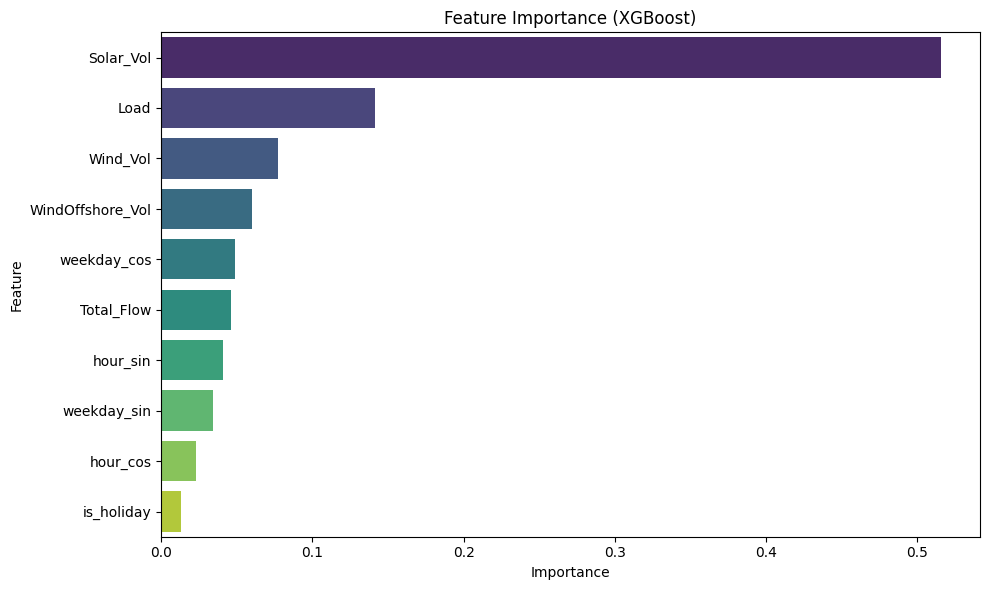

In [14]:
# Get feature importances from the last trained model
importances = model.feature_importances_
feature_names = model.feature_names_in_

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feat_imp_df)

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()